In [1]:
import pennylane as qml # To define the circuit
from pprop.propagator import Propagator # For Pauli Propagation
import numpy as np
from sklearn.datasets import load_digits

In [2]:
digits = load_digits().images
digits[digits < (np.max(digits) - np.min(digits)) / 2] = 0
digits[digits != 0] = 1
digits_flatten = digits.reshape(len(digits), -1)

In [3]:
def sample_a(n: int, sigma: float) -> np.ndarray:
    p_sigma = (1 - np.exp(-1 / (2 * sigma))) / 2
    return np.random.binomial(1, p_sigma, size=n)

def get_Za(a, X):
    # Dot product mod 2 (parity)
    parity = (X @ a) % 2  
    # Map parity {0,1} -> {+1,-1}
    values = 1 - 2*parity  
    return values.mean()

side = 8
sigmas = [0.001, 0.01, 0.1]
p_a = [sample_a(side * side, np.random.choice(sigmas)) for _ in range(1000)]
Za = [get_Za(a, digits_flatten) for a in p_a]


In [4]:
def xy_to_i(x, y, side = 8):
    return x + side*y

def grid_centers(side: int) -> list[tuple[int, int]]:
    centers = []
    if side % 2 == 1:
        # Odd side → single center cell
        mid = side // 2
        centers.append((mid, mid))
    else:
        # Even side → 2x2 inner square
        mid1, mid2 = side // 2 - 1, side // 2
        centers = [(x, y) for x in (mid1, mid2) for y in (mid1, mid2)]
    return centers

def ansatz2D_builder(side):
    def ansatz2D(params): 
        centers = grid_centers(side)
        targeted = set(centers)   # visited sites
        controls = centers[:]     # frontier sites
        
        idx_params = 0
        while controls:
            next_controls = []
            for c in controls:
                # apply a single RY rotation on this site
                qml.RY(params[idx_params], wires=xy_to_i(c[0], c[1], side))
                idx_params += 1

                # spread entanglement to neighbors
                for nx, ny in [(c[0]+1, c[1]), (c[0]-1, c[1]), (c[0], c[1]+1), (c[0], c[1]-1)]:
                    if 0 <= nx < side and 0 <= ny < side and (nx, ny) not in targeted:
                        qml.CNOT(wires=[xy_to_i(c[0], c[1], side), xy_to_i(nx, ny, side)])
                        next_controls.append((nx, ny))
                        targeted.add((nx, ny))
                        
            controls = next_controls

        terms = []
        for a in p_a:
            idxs = np.nonzero(a)[0].tolist()
            if idxs:  # only build nontrivial product
                terms.append(qml.prod(*(qml.PauliZ(i) for i in idxs)))
        
        p_op = terms
        return [qml.expval(op) for op in p_op]
        
    return ansatz2D

In [5]:
prop = Propagator(ansatz2D_builder(8))
prop

Propagator
  Number of qubits : 64
  Trainable parameters : 64
  Cutoff 1: None | Cutoff 2: None
  Observables [Z(2) @ Z(3) @ Z(4) @ Z(6) @ Z(7) @ Z(8) @ Z(12) @ Z(14) @ Z(18) @ Z(19) @ Z(20) @ Z(21) @ Z(22) @ Z(23) @ Z(27) @ Z(29) @ Z(30) @ Z(31) @ Z(33) @ Z(35) @ Z(37) @ Z(38) @ Z(39) @ Z(41) @ Z(44) @ Z(45) @ Z(46) @ Z(50) @ Z(51) @ Z(55) @ Z(56) @ Z(58) @ Z(61), Z(2) @ Z(3) @ Z(8) @ Z(12) @ Z(14) @ Z(15) @ Z(16) @ Z(25) @ Z(27) @ Z(28) @ Z(32) @ Z(36) @ Z(41) @ Z(42) @ Z(48) @ Z(49) @ Z(50) @ Z(51) @ Z(53) @ Z(54) @ Z(58) @ Z(59) @ Z(60), Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(7) @ Z(8) @ Z(10) @ Z(12) @ Z(13) @ Z(15) @ Z(16) @ Z(17) @ Z(18) @ Z(21) @ Z(26) @ Z(27) @ Z(29) @ Z(30) @ Z(32) @ Z(35) @ Z(39) @ Z(44) @ Z(45) @ Z(49) @ Z(50) @ Z(51) @ Z(53) @ Z(55) @ Z(57) @ Z(59) @ Z(62) @ Z(63), Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(7) @ Z(8) @ Z(9) @ Z(11) @ Z(18) @ Z(20) @ Z(23) @ Z(24) @ Z(25) @ Z(26) @ Z(27) @ Z(29) @ Z(31) @ Z(36) @ Z(38) @ Z(40) @ Z(43) @ Z(44) @ Z(45) @ Z(47) @ Z(51) @ Z(52) @ Z

In [6]:
prop.propagate()

Propagating Z(2) @ Z(3) @ Z(4) @ Z(5) @ Z(8) @ Z(10) @ Z(17) @ Z(19) @ Z(20) @ Z(21) @ Z(22) @ Z(25) @ Z(26) @ Z(30) @ Z(31) @ Z(33) @ Z(36) @ Z(37) @ Z(38) @ Z(43) @ Z(46) @ Z(48) @ Z(50) @ Z(53) @ Z(55) @ Z(56) @ Z(61) @ Z(62) @ Z(63): 100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]                                                                                                                     


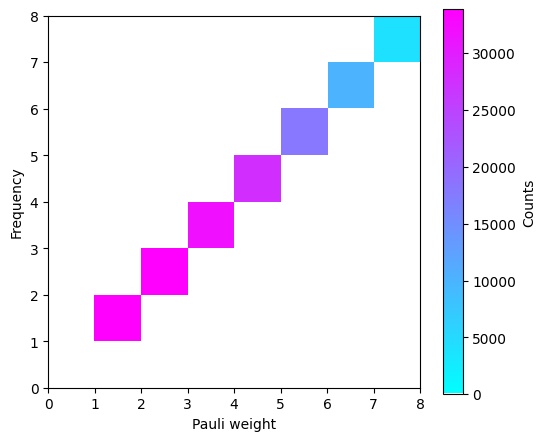

In [7]:
from pprop.plot.obs import plot_obs2D
plot_obs2D(prop)

In [8]:
def loss(values):
    return np.mean(np.square(values - Za))

In [9]:
res = prop.minimize(loss, method="ADAM")

In [10]:
res.fun

np.float64(0.0006951403518413776)

In [11]:
prop.loss_hist

[np.float64(202.4399751382045),
 np.float64(159.78825682708663),
 np.float64(123.83414448703252),
 np.float64(94.38884526732573),
 np.float64(70.90967692284828),
 np.float64(52.63110073479341),
 np.float64(38.693641279939506),
 np.float64(28.24889163567962),
 np.float64(20.529393670130567),
 np.float64(14.88390827847427),
 np.float64(10.785933429159059),
 np.float64(7.825286451105778),
 np.float64(5.691338193691929),
 np.float64(4.153812407285812),
 np.float64(3.044652875943345),
 np.float64(2.2425498072340555),
 np.float64(1.6605596603713089),
 np.float64(1.236621672904393),
 np.float64(0.9265044382605732),
 np.float64(0.6986697183870672),
 np.float64(0.5305846406079899),
 np.float64(0.4060988333522121),
 np.float64(0.3135891960001791),
 np.float64(0.24465115575498664),
 np.float64(0.19317597595902009),
 np.float64(0.15469945369351376),
 np.float64(0.12594101463327873),
 np.float64(0.10447643680764708),
 np.float64(0.08850447529868959),
 np.float64(0.07667965567205873),
 np.float64(0.

In [13]:
res.x

array([1.56722176, 1.56871419, 1.57062565, 1.57254839, 1.64511264,
       1.2840958 , 1.63507985, 1.68129841, 1.51306106, 1.77057906,
       1.19652006, 1.3382381 , 1.44486839, 1.17076974, 1.56358518,
       1.13644706, 1.12150222, 1.34050529, 1.29773614, 1.42941269,
       1.05932792, 1.66935999, 1.16242965, 1.13441813, 0.94637765,
       1.18994656, 1.53212204, 1.10512304, 1.37152808, 1.33576592,
       1.70820315, 1.30961486, 1.43142222, 0.93798619, 1.6088769 ,
       0.89118287, 1.20026841, 1.00247894, 1.10719265, 1.77541694,
       1.67796048, 1.61820111, 0.97152065, 1.37567181, 1.1434372 ,
       1.27050035, 1.49249967, 1.55991471, 0.98732883, 1.66803688,
       0.99724612, 1.66763135, 0.94332143, 1.03566158, 1.28165836,
       1.28352177, 1.13719892, 0.9560408 , 1.46904753, 1.58421742,
       1.07699446, 1.50968185, 1.28226578, 1.32658441])

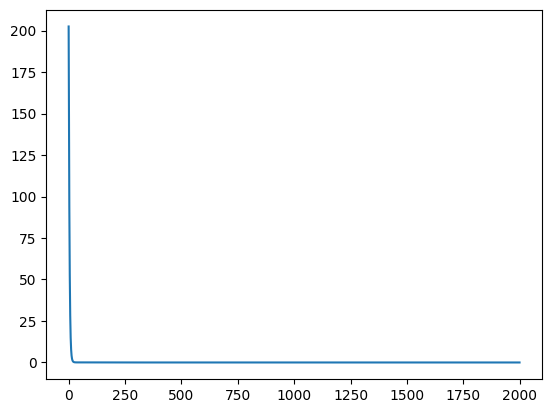

In [12]:
import matplotlib.pyplot as plt
plt.plot(prop.loss_hist)